In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
"""Main training script for Cascaded Nets."""
import argparse
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch
pd.set_option('mode.chained_assignment', None)
from collections import defaultdict
from datasets.dataset_handler import DataHandler
from matplotlib.lines import Line2D
from modules import utils
from scipy import interpolate

In [127]:
# # sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# # pip install latex
# from matplotlib import rc

# rc('text',usetex=True)
# rc('text.latex', preamble='\\usepackage{color}')

In [128]:
def setup_args():
  parser = argparse.ArgumentParser()
  parser.add_argument("--random_seed", type=int, default=42,
                      help="random seed")
  
  # Paths
  parser.add_argument("--experiment_root", type=str, 
                      default='experiments',
                      help="Local output dir")
#   parser.add_argument("--experiment_name", type=str, 
#                       required=True,
#                       help="Experiment name")
  
  # Dataset
#   parser.add_argument("--dataset_root", type=str, required=True,
#                       help="Dataset root")
#   parser.add_argument("--dataset_name", type=str, required=True,
#                       help="Dataset name: CIFAR10, CIFAR100, TinyImageNet")
  parser.add_argument("--split_idxs_root", type=str, default='split_idxs',
                      help="Split idxs root")
  parser.add_argument("--val_split", type=float, default=0.1,
                      help="Validation set split: 0.1 default")
  parser.add_argument("--augmentation_noise_type", type=str, 
                      default='occlusion',
                      help="Augmentation noise type: occlusion")
  parser.add_argument("--batch_size", type=int, default=128,
                      help="batch_size")
  parser.add_argument("--num_workers", type=int, default=2,
                      help="num_workers")
  parser.add_argument('--drop_last', action='store_true', default=False,
                      help='Drop last batch remainder')
  
  # Model
  parser.add_argument("--model_key", type=str, default='resnet18',
                      help="Model: resnet18, resnet34, ..., densenet_cifar")
  parser.add_argument("--train_mode", type=str, 
                      default='baseline',
                      help="Train mode: baseline, ic_only, sdn")
  parser.add_argument('--bn_time_affine', action='store_true', default=False,
                      help='Use temporal affine transforms in BatchNorm')
  parser.add_argument('--bn_time_stats', action='store_true', default=False,
                      help='Use temporal stats in BatchNorm')
  parser.add_argument("--tdl_mode", type=str, 
                      default='OSD',
                      help="TDL mode: OSD, EWS, noise")
  parser.add_argument("--tdl_alpha", type=float, default=0.0,
                      help="TDL alpha for EWS temporal kernel")
  parser.add_argument("--noise_var", type=float, default=0.0,
                      help="Noise variance on noise temporal kernel")
  parser.add_argument("--lambda_val", type=float, default=1.0,
                      help="TD lambda value")
  parser.add_argument('--cascaded', action='store_true', default=False,
                      help='Cascaded net')
  parser.add_argument("--cascaded_scheme", type=str, default='parallel',
                      help="cascaded_scheme: serial, parallel")
  parser.add_argument("--init_tau", type=float, default=0.01,
                      help="Initial tau valu")
  parser.add_argument("--target_IC_inference_costs", nargs="+", type=float, 
                      default=[0.15, 0.30, 0.45, 0.60, 0.75, 0.90],
                      help="target_IC_inference_costs")
  parser.add_argument('--tau_weighted_loss', action='store_true', default=False,
                      help='Use tau weights on IC losses')
  
  
  # Optimizer
  parser.add_argument("--learning_rate", type=float, default=0.1,
                      help="learning rate")
  parser.add_argument("--momentum", type=float, default=0.9,
                      help="momentum")
  parser.add_argument("--weight_decay", type=float, default=0.0005,
                      help="weight_decay")
  parser.add_argument('--nesterov', action='store_true', default=False,
                      help='Nesterov for SGD')
  parser.add_argument('--normalize_loss', action='store_true', default=False,
                      help='Normalize temporal loss')
  
  # LR scheduler
  parser.add_argument("--lr_milestones", nargs="+", type=float, 
                      default=[60, 120, 150],
                      help="lr_milestones")
  parser.add_argument("--lr_schedule_gamma", type=float, default=0.2,
                      help="lr_schedule_gamma")
  
  # Other
  parser.add_argument('--use_cpu', action='store_true', default=False,
                      help='Use cpu')
  parser.add_argument("--device", type=int, default=0,
                      help="GPU device num")
  parser.add_argument("--n_epochs", type=int, default=150,
                      help="Number of epochs to train")
  parser.add_argument("--eval_freq", type=int, default=10,
                      help="eval_freq")
  parser.add_argument("--save_freq", type=int, default=5,
                      help="save_freq")
  parser.add_argument('--keep_logits', action='store_true', default=False,
                      help='Keep logits')
  parser.add_argument('--debug', action='store_true', default=False,
                      help='Debug mode')
  
  args = parser.parse_args("")
  
  # Flag check
  if args.tdl_mode == 'EWS':
    assert args.tdl_alpha is not None, 'tdl_alpha not set'
  elif args.tdl_mode == 'noise':
    assert args.noise_var is not None, 'noise_var not set'
    
  return args

In [129]:
casc_seq_color = np.array((54,129,179)) / 255.

In [198]:
figs_root = "figs/distillation"
if not os.path.exists(figs_root):
  os.makedirs(figs_root)

In [131]:
args = setup_args()

args.dataset_root = '/hdd/mliuzzolino/datasets'
args.experiment_root = '/home/mliuzzolino/experiment_output'
  
# Set required flags|
args.dataset_name = 'CIFAR100'  # CIFAR10, CIFAR100, ImageNet2012
args.model_key = 'resnet18_small'  # resnet18, resnet18_small
args.dataset_key = 'test'  # val, test
if args.dataset_name == "ImageNet2012":
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
elif "cifar" in args.dataset_name.lower():
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
else:
  print("TinyImageNet not implemented yet!")
  
args.val_split = 0.1
args.test_split = 0.1
args.split_idxs_root = "/hdd/mliuzzolino/split_idxs"
args.tdl_mode = 'OSD'  # OSD, EWS
args.tau_weighted_loss = True
args.random_seed = 42

In [132]:
# Make reproducible
utils.make_reproducible(args.random_seed)

Making reproducible on seed 42


In [133]:
# Data Handler
data_dict = {
    "dataset_name": args.dataset_name,
    "data_root": args.dataset_root,
    "val_split": args.val_split,
    "test_split": args.test_split,
    "split_idxs_root": args.split_idxs_root,
    "noise_type": args.augmentation_noise_type,
    "load_previous_splits": True,
    "imagenet_params": {
      "target_classes": ["terrier"],
      "max_classes": 10,
    }
}
data_handler = DataHandler(**data_dict)

Setting split idxs root to /hdd/mliuzzolino/split_idxs/CIFAR100
Loading CIFAR100 train data...
Files already downloaded and verified
Loading previous splits from /hdd/mliuzzolino/split_idxs/CIFAR100/10-90_val_split.json
45,000 train examples loaded.
5,000 val examples loaded.
50,000 dev examples loaded.
Loading CIFAR100 test data...
Files already downloaded and verified
10,000 test examples loaded.


In [134]:
# Set Loaders
test_loader = data_handler.build_loader(args.dataset_key, args)

In [135]:
# Set experiment root
exp_root = os.path.join(args.experiment_root,
                        args.experiment_name,
                        'experiments')

exp_root = f"/hdd/mliuzzolino/cascaded_distillation_nets/{args.experiment_name}/experiments"

# Find exp paths
exp_paths = np.sort(glob.glob(f'{exp_root}/*/outputs/*__{args.dataset_key}__{args.tdl_mode}.pt'))
print(f"Num paths: {len(exp_paths)}")

Num paths: 75


In [136]:
n_cascaded = 4
n_sdn = 3
cascaded_palette = plt.cm.cool(np.linspace(0, 1, n_cascaded+2))[1:-1][:,:3][::-1]
sdn_palette = plt.cm.Oranges(np.linspace(0, 1, n_sdn+2))[1:-1][:,:3]

PALETTE = np.concatenate([cascaded_palette, sdn_palette])

In [156]:
df_dict = defaultdict(list)
outreps_dict = {}
for i, root in enumerate(exp_paths):
  if "td(0.5)" in root and "alpha_0.0" in root and "wd_0.001" not in root:
    continue
    
  outrep_id = f'rep_id_{i}'
  outreps_dict[outrep_id] = torch.load(root)

  exp_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
  distillation = False
  alpha = -1
  td = -1
  if exp_name.startswith("std"):
    model_key = "std"
    if "distillation" in exp_name:
      distillation = True
      alpha = float(exp_name.split("alpha_")[1])
  elif "cascaded_seq__parallel" in exp_name:
    model_key = "cascaded_seq"
    if "distillation" in exp_name:
      _, lr, wd, seed, _, alpha = exp_name.split(",")
      alpha = float(alpha.split("_")[1])
    else:
      _, lr, wd, seed = exp_name.split(",")
    distillation = True
  elif "distillation" in exp_name:
    model_key = "cascaded"
    td, mode, lr, wd, seed, _, alpha = exp_name.split(",")
    td = float(td.replace("td(", "").replace(")", ""))
    alpha = float(alpha.split("_")[1])
    distillation = True
  else:
    model_key = "cascaded"
    td, mode, lr, wd, seed = exp_name.split(",")
    td = float(td.replace("td(", "").replace(")", ""))
 
  lr = float(root.split("lr_")[1].split(",")[0])
 
  df_dict["model"].append(model_key)
  df_dict["distillation"].append(distillation)
  df_dict["td_lambda"].append(td)
  df_dict["alpha"].append(alpha)
  df_dict["lr"].append(lr)
  
  df_dict['outrep_id'].append(outrep_id)
analysis_df = pd.DataFrame(df_dict)

In [157]:
def print_model_lambda(df):
  for model_key, model_df in df.groupby('model'):
    for td_lambda, td_df in model_df.groupby('td_lambda'):
      for alpha, alpha_df in model_df.groupby('alpha'):
        for distillation, _ in alpha_df.groupby('distillation'):
          print(model_key, f"td={td_lambda}", f"alpha={alpha}", "Distillation" if distillation else "No-Distillation")

In [158]:
print_model_lambda(analysis_df)

cascaded td=0.0 alpha=-1.0 No-Distillation
cascaded td=0.0 alpha=0.0 Distillation
cascaded td=0.0 alpha=0.25 Distillation
cascaded td=0.0 alpha=0.5 Distillation
cascaded td=0.0 alpha=0.75 Distillation
cascaded td=0.0 alpha=1.0 Distillation
cascaded td=0.1 alpha=-1.0 No-Distillation
cascaded td=0.1 alpha=0.0 Distillation
cascaded td=0.1 alpha=0.25 Distillation
cascaded td=0.1 alpha=0.5 Distillation
cascaded td=0.1 alpha=0.75 Distillation
cascaded td=0.1 alpha=1.0 Distillation
cascaded td=0.25 alpha=-1.0 No-Distillation
cascaded td=0.25 alpha=0.0 Distillation
cascaded td=0.25 alpha=0.25 Distillation
cascaded td=0.25 alpha=0.5 Distillation
cascaded td=0.25 alpha=0.75 Distillation
cascaded td=0.25 alpha=1.0 Distillation
cascaded td=0.5 alpha=-1.0 No-Distillation
cascaded td=0.5 alpha=0.0 Distillation
cascaded td=0.5 alpha=0.25 Distillation
cascaded td=0.5 alpha=0.5 Distillation
cascaded td=0.5 alpha=0.75 Distillation
cascaded td=0.5 alpha=1.0 Distillation
cascaded td=0.55 alpha=-1.0 No-Dis

# Stats

In [159]:
df_dict = defaultdict(list)
analysis_df = analysis_df.sort_values('model')
for i, df_i in analysis_df.iterrows():
  outrep_i = outreps_dict[df_i.outrep_id]
  accs = outrep_i['correct'].float().mean(dim=1)
  
  for i, acc in enumerate(accs):
    df_dict['acc'].append(acc.item() * 100)
    if len(accs) == 1:
      i = -1
    df_dict['ic'].append(i)
    for k in list(df_i.index):
      df_dict[k].append(df_i[k])
accs_df = pd.DataFrame(df_dict)

In [160]:
# print_model_lambda(accs_df)

In [161]:
accs_df = accs_df.sort_values(['outrep_id', 'ic'])

df_dict = defaultdict(list)
for model_key, model_df in accs_df.groupby('model'):
  for td_lambda, lambda_df in model_df.groupby('td_lambda'):
    for alpha_val, alpha_df in lambda_df.groupby('alpha'):
      for distillation, distillation_df in alpha_df.groupby('distillation'):
        for ic, ic_df in distillation_df.groupby('ic'):
          mean_acc = np.mean(ic_df.acc)
          sem_acc = np.std(ic_df.acc) / np.sqrt(len(ic_df.acc))
          outrep_id = ic_df.outrep_id.iloc[0]
          df_dict['model'].append(model_key)
          df_dict['td_lambda'].append(td_lambda)
          df_dict['alpha'].append(alpha_val)
          df_dict['distillation'].append(distillation)
          df_dict['ic'].append(ic)
          df_dict['acc'].append(mean_acc)
          df_dict['sem'].append(sem_acc)
          df_dict['outrep_id'].append(outrep_id)
stats_df = pd.DataFrame(df_dict)
stats_df.loc[stats_df.ic==-1, 'ic'] = np.max(stats_df.ic)
stats_df.ic = [ele+1 for ele in stats_df.ic]

In [162]:
# print_model_lambda(stats_df)

## Inference Cost as it varies with confidence threshold, q

In [163]:
def compute_threshold_conf_correct(pred_conf, correct, q):
  correct_arr = []
  best_clf_idxs = []
  n_clfs = pred_conf.shape[0]
  n_samples = pred_conf.shape[1]
  for i in range(n_samples):
    pred_conf_i = pred_conf[:,i]
    idxs = np.where(pred_conf_i >= q)[0]
    if not len(idxs):
      best_clf_idx = n_clfs - 1
      cor_i = correct[best_clf_idx,i]
    else:
      best_clf_idx = idxs[0]
      cor_i = correct[best_clf_idx,i]
    correct_arr.append(cor_i)
    best_clf_idxs.append(best_clf_idx)
  avg_acc = np.mean(correct_arr)
  return avg_acc, best_clf_idxs

In [164]:
save_dir = "/hdd/mliuzzolino/cascaded_nets/save_dfs"
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

In [165]:
TRY_LOAD = False

Q_DELTA = 50
q_df_path = os.path.join(save_dir, f"q_{Q_DELTA}.csv")

if os.path.exists(q_df_path) and TRY_LOAD:
  print(f"Loading from {q_df_path}...")
  x_df = pd.read_csv(q_df_path)
else:
  print("Generating new df...")
  df_dict = defaultdict(list)
  n_total = len(analysis_df.groupby(["td_lambda", "alpha", "distillation", "model"]))
  i = 0
  Qs = np.linspace(0, 1, Q_DELTA)
  for model_key, model_df in analysis_df.groupby('model'):
    print(f"\nModel: {model_key}")
    for (td_lambda, alpha_val, distillation), td_df in model_df.groupby(["td_lambda", "alpha", "distillation"]):
      for jj, df_i in td_df.iterrows():
        outrep_id = df_i.outrep_id
        outrep_i = outreps_dict[outrep_id]

        prediction_confidence = outrep_i['prediction_confidence']
        correct_vals = outrep_i['correct']
        accs = []
        for qi, q in enumerate(Qs):
          sys.stdout.write((f'\rDF {i+1}/{n_total} -- '
                            f'Threshold, q: {q:0.2f} [{qi+1}/{len(Qs)}]'))
          sys.stdout.flush()
          acc_i, best_clf_idxs = compute_threshold_conf_correct(prediction_confidence, correct_vals, q)
          avg_timesteps = np.mean(best_clf_idxs)

          df_dict['model'].append(model_key)
          df_dict['td_lambda'].append(td_lambda)
          df_dict['alpha'].append(alpha_val)
          df_dict['distillation'].append(distillation)
          df_dict['acc'].append(acc_i * 100)
          df_dict['timesteps'].append(avg_timesteps)
          df_dict['q'].append(q)
        i += 1
  x_df = pd.DataFrame(df_dict)
  print(f"Saving df to {q_df_path}...")
  x_df.to_csv(q_df_path, index=False)
print("Complete.")

Generating new df...

Model: cascaded
DF 60/55 -- Threshold, q: 1.00 [50/50]
Model: cascaded_seq
DF 66/55 -- Threshold, q: 1.00 [50/50]
Model: std
DF 72/55 -- Threshold, q: 1.00 [50/50]Saving df to /hdd/mliuzzolino/cascaded_nets/save_dfs/q_50.csv...
Complete.


### Agg Stats

In [166]:
def create_dt_df(df):
  df_dict = defaultdict(list)
  for exp_key, df_i in df.groupby("exp_key"):
    vals = np.array(df_i.acc_mean)
    for i in range(len(vals) - 1):
      dt = 0 if i == 0 else vals[i] - prev_val
      prev_val = vals[i]

      # Normalize by asymptotic value
      df_dict["t"].append(i)
      df_dict["dt"].append(dt)
      
      for key in df_i.columns:
        df_dict[key].append(df_i.iloc[0][key])
  return pd.DataFrame(df_dict)

In [167]:
df_dict = defaultdict(list)
lis = ["model", "td_lambda", "alpha", "distillation"]
for (model_key, td_lambda, alpha, distillation), td_df in x_df.groupby(lis):
  agg_dict = defaultdict(list)
  for q, q_df in td_df.groupby('q'):
    acc_mean = np.mean(q_df.acc)
    n = len(q_df)
    acc_sem = np.std(q_df.acc) / np.sqrt(n)
    timestep_mean = np.mean(q_df.timesteps)
    timestep_sem = np.std(q_df.timesteps) / np.sqrt(n)
    
    agg_dict['q'].append(q)
    agg_dict['acc_mean'].append(acc_mean)
    agg_dict['acc_sem'].append(acc_sem)
    agg_dict['timestep_mean'].append(timestep_mean)
    agg_dict['timestep_sem'].append(timestep_sem)
    agg_dict['n'].append(n)
  
  # Sort by timesteps
  unsorted_timesteps = np.array(list(agg_dict["timestep_mean"]))
  sorted_idxs = np.argsort(unsorted_timesteps)
  sorted_dict = {}
  for key, vals in agg_dict.items():
    sorted_dict[key] = np.array(list(vals))[sorted_idxs]
  
  for i in range(unsorted_timesteps.shape[0]):
    for key, vals in agg_dict.items():
      df_dict[key].append(vals[i])
    
    if model_key == "cascaded":
      exp_key = r"CascadedTD({}), $\alpha$={:0.2f}".format(td_lambda, alpha)
    else:
      exp_key = r"CascadedSeq, $\alpha$={:0.2f}".format(alpha)
      
    df_dict['exp_key'].append(exp_key)
    df_dict['model'].append(model_key)
    df_dict['alpha'].append(alpha)
    df_dict['distillation'].append(distillation)
    df_dict['td_lambda'].append(td_lambda)
agg_df_src = pd.DataFrame(df_dict)

In [387]:
std_df = agg_df_src[agg_df_src.model=="std"]
agg_df = agg_df_src[agg_df_src.model!="std"]

# Filter out bad / unwanted runs
agg_df = agg_df[~(agg_df.td_lambda==0.1)]
agg_df = agg_df[~((~agg_df.distillation) & (agg_df.model=="cascaded"))]
# agg_df = agg_df[~((agg_df.model=="cascaded_seq") & (agg_df.alpha.isin([-1.0, 1.0])))]
agg_df = agg_df[~((agg_df.model=="cascaded_seq") & (agg_df.alpha.isin([-1.0])))]
agg_df = agg_df[agg_df.td_lambda != 0.55]

In [182]:
cmaps = {
  "cascaded": plt.cm.magma,
  "cascaded_seq": plt.cm.cool,
}
colors = {}
for model, df_i in agg_df.groupby("model"):
  cmap = cmaps[model]
  n_colors = len(df_i.groupby("td_lambda"))
  colors[model] = cmap(np.linspace(0, 1, n_colors+2))[1:-1]

## Aggregate Plot

In [183]:
CASCADED_SEQ_COLOR = np.array((54,129,179)) / 255.0
LINEWIDTH = 3.5

In [184]:
def df_to_xy(df_i, key="alpha"):
  zip_g = df_i.groupby(key).apply(lambda x: list(zip(x['timestep_mean'], x['acc_mean'])))

  X = []
  y = []
  for ele in zip_g:
    xi = np.array(ele)[:,0]
    yi = np.array(ele)[:,1]
    X.append(xi)
    y.append(yi)
  
  X_mean = np.vstack(X).mean(axis=0)
  y_mean = np.vstack(y).mean(axis=0)
  y_sem = np.vstack(y).std(axis=0) / np.sqrt(len(y))
  return X_mean, y_mean, y_sem

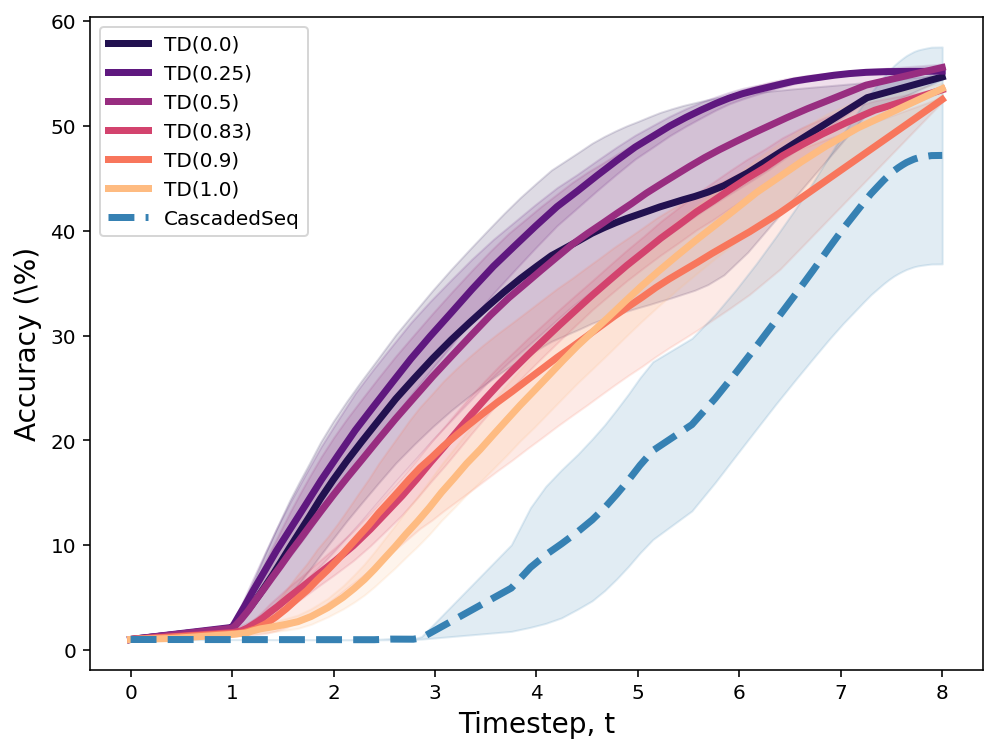

In [199]:
KEY1 = "td_lambda"  # alpha, td_lambda
KEY2 = "alpha" if KEY1 == "td_lambda" else "alpha"
casc_df = agg_df[agg_df.model=="cascaded"]
casc_seq_df = agg_df[agg_df.model=="cascaded_seq"]

plt.figure(figsize=(8,6))
casc_g = casc_df.groupby(KEY1)
colors = plt.cm.magma(np.linspace(0, 1, len(casc_g)+2))[1:-1]
for i, (td_lambda, df_i) in enumerate(casc_g):
  X, y, y_err = df_to_xy(df_i, key=KEY2)
  plt.plot(
    X,
    y,
    label=f"TD({td_lambda})",
    c=colors[i],
    lw=LINEWIDTH,
    ls="-",
  )
  plt.fill_between(
    X, 
    y - y_err, 
    y + y_err, 
    alpha=0.15,
    color=colors[i],
  )
  
X, y, y_err = df_to_xy(casc_seq_df)
plt.plot(
  X,
  y,
  label=f"CascadedSeq",
  c=casc_seq_color,
  lw=LINEWIDTH,
  ls="--",
)
plt.fill_between(
  X, 
  y - y_err, 
  y + y_err, 
  alpha=0.15,
  color=casc_seq_color,
)

plt.legend()
plt.xlabel("Timestep, t", fontsize=14)
plt.ylabel("Accuracy (\%)", fontsize=14);

save_path = os.path.join(figs_root, "TD_speed_acc_curves_agg.pdf")
plt.savefig(save_path, dpi=300)
plt.savefig(save_path.replace(".pdf", ".png"), dpi=300)

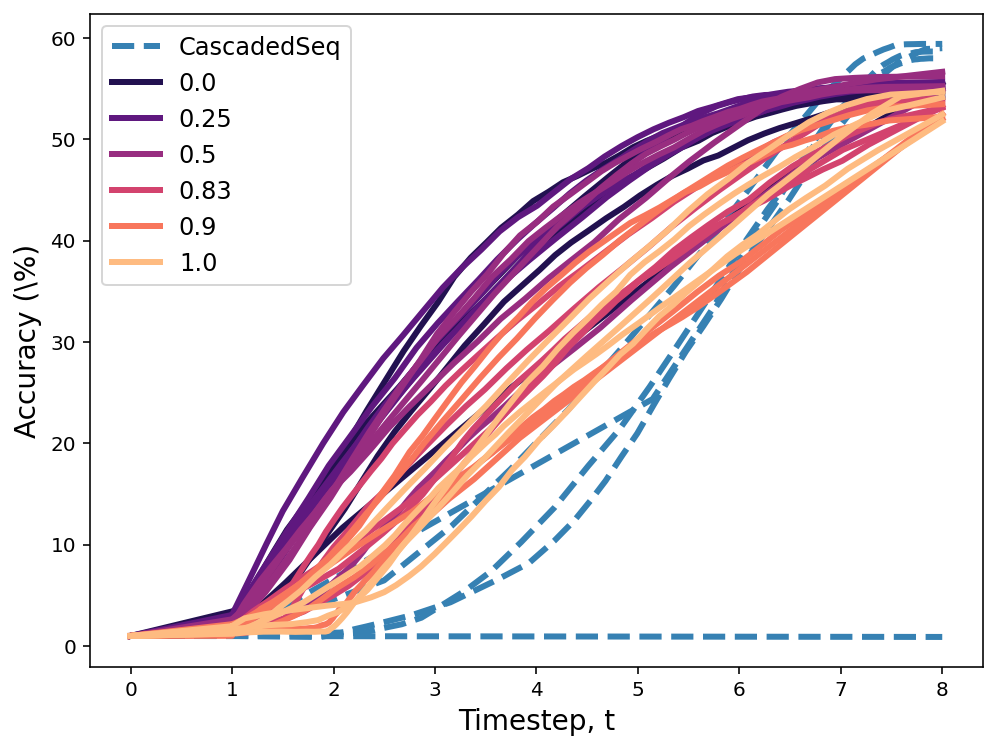

In [186]:
cmaps = {
  "cascaded": plt.cm.magma,
  "cascaded_seq": plt.cm.cool,
}
colors = {}
for model, df_i in agg_df.groupby("model"):
  cmap = cmaps[model]
  n_colors = len(df_i.groupby("td_lambda"))
  colors[model] = cmap(np.linspace(0, 1, n_colors+2))[1:-1]
  
plt.figure(figsize=(8,6))
unique_td_lambdas = agg_df.td_lambda.unique()
unique_td_lambdas = list(unique_td_lambdas[unique_td_lambdas >= 0])
seen_labels = []
for i, (exp_key, df_i) in enumerate(agg_df.groupby("exp_key")):
  model_key = df_i.iloc[0].model
  td_lambda = df_i.iloc[0].td_lambda
  if model_key == "cascaded":
    idx = np.where(unique_td_lambdas==td_lambda)[0][0]
    color = colors[model_key][idx]
    ls = "-"
    label = td_lambda
  else:
    color = CASCADED_SEQ_COLOR
    ls = "--"
    label = "CascadedSeq"
  if label in seen_labels:
    label = None
  seen_labels.append(label)
  plt.plot(
    list(df_i.timestep_mean),
    list(df_i.acc_mean),
    label=label,
    ls=ls,
    color=color,
    lw=3,
  )
plt.legend(prop={"size": 12})
plt.xlabel("Timestep, t", fontsize=14)
plt.ylabel("Accuracy (\%)", fontsize=14);

save_path = os.path.join(figs_root, "TD_speed_acc_curves_multi.pdf")
plt.savefig(save_path, dpi=300)
plt.savefig(save_path.replace(".pdf", ".png"), dpi=300)

## Asymptotic

In [187]:
def create_asymp_df(df):
  save_keys = ["exp_key", "model", "td_lambda", "alpha", "distillation"]
  df_dict = defaultdict(list)
  for exp_key, df_i in df.groupby("exp_key"):
    asymp_val = np.array(df_i.acc_mean)[-1]
    df_dict["asymp"].append(asymp_val)
    for key in save_keys:
      df_dict[key].append(df_i.iloc[0][key])
  asymp_df = pd.DataFrame(df_dict)
  return asymp_df

In [188]:
asymp_df = create_asymp_df(agg_df)
asymp_df = asymp_df.sort_values(['asymp'], ascending=False).reset_index(drop=True)

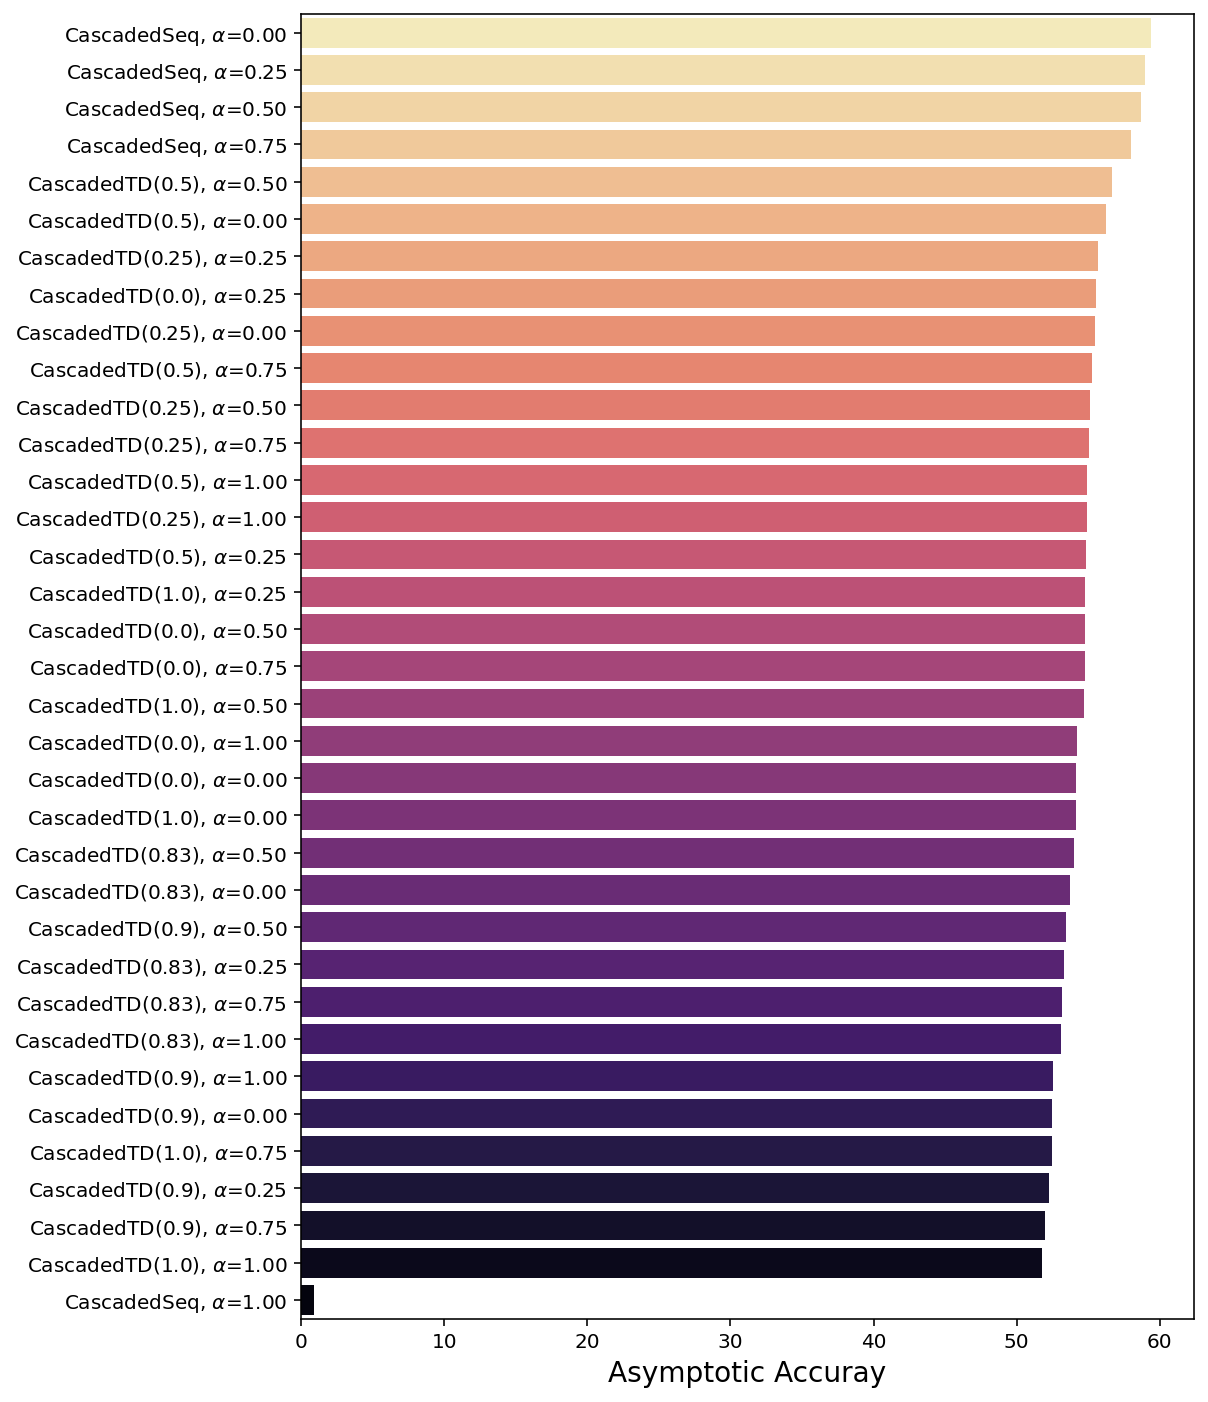

In [189]:
plt.figure(figsize=(8, 12))
g = sns.barplot(y="exp_key", x="asymp", data=asymp_df, palette="magma_r")
g.set_xlabel("Asymptotic Accuray", fontsize=14)
g.set_ylabel("");

## Heatmap

In [190]:
def plot_arrow(
    g, 
    text, 
    x_start=0.0, 
    x_length=1.0, 
    y=1.0, 
    arrowstyle="->", 
    text_delta=0.22,
    fs=10.0,
):
  x_end = x_start + x_length
  g.annotate(
      s=" ",
      xy=(x_start, y), 
      xycoords='data',
      xytext=(x_end, y),
      textcoords='data',
      fontsize=fs,
      arrowprops=dict(arrowstyle=arrowstyle),
      va="center",
      ha="center",
      annotation_clip=False,
  )
  g.annotate(
      s=text,
      xy=(((x_start + x_end)/2), y + text_delta),
      xycoords='data',
      fontsize=fs,
      textcoords='data',
      va="center",
      ha="center",
      annotation_clip=False,
  )

In [191]:
CBAR_SHRINK_FACTOR = 1.0

In [192]:
result = asymp_df.pivot(index="td_lambda", columns="alpha", values="asymp")

result = result.loc[np.roll(result.index, 1)]
result

alpha,0.00,0.25,0.50,0.75,1.00
td_lambda,,,,,
1.00,54.140002,54.799998,54.689997,52.440000,51.779997
-1.00,59.420002,58.999997,58.670002,57.999998,0.900000
0.00,54.159999,55.570000,54.769999,54.740000,54.189998
0.25,55.440003,55.669999,55.110002,55.049998,54.930001
0.50,56.230003,54.860002,56.669998,55.250001,54.939997
0.83,53.705001,53.320003,54.025000,53.140002,53.130001
0.90,52.460000,52.230000,53.470001,51.999998,52.509999


<ipython-input-190-369712ab86fa>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  g.annotate(
<ipython-input-190-369712ab86fa>:24: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  g.annotate(


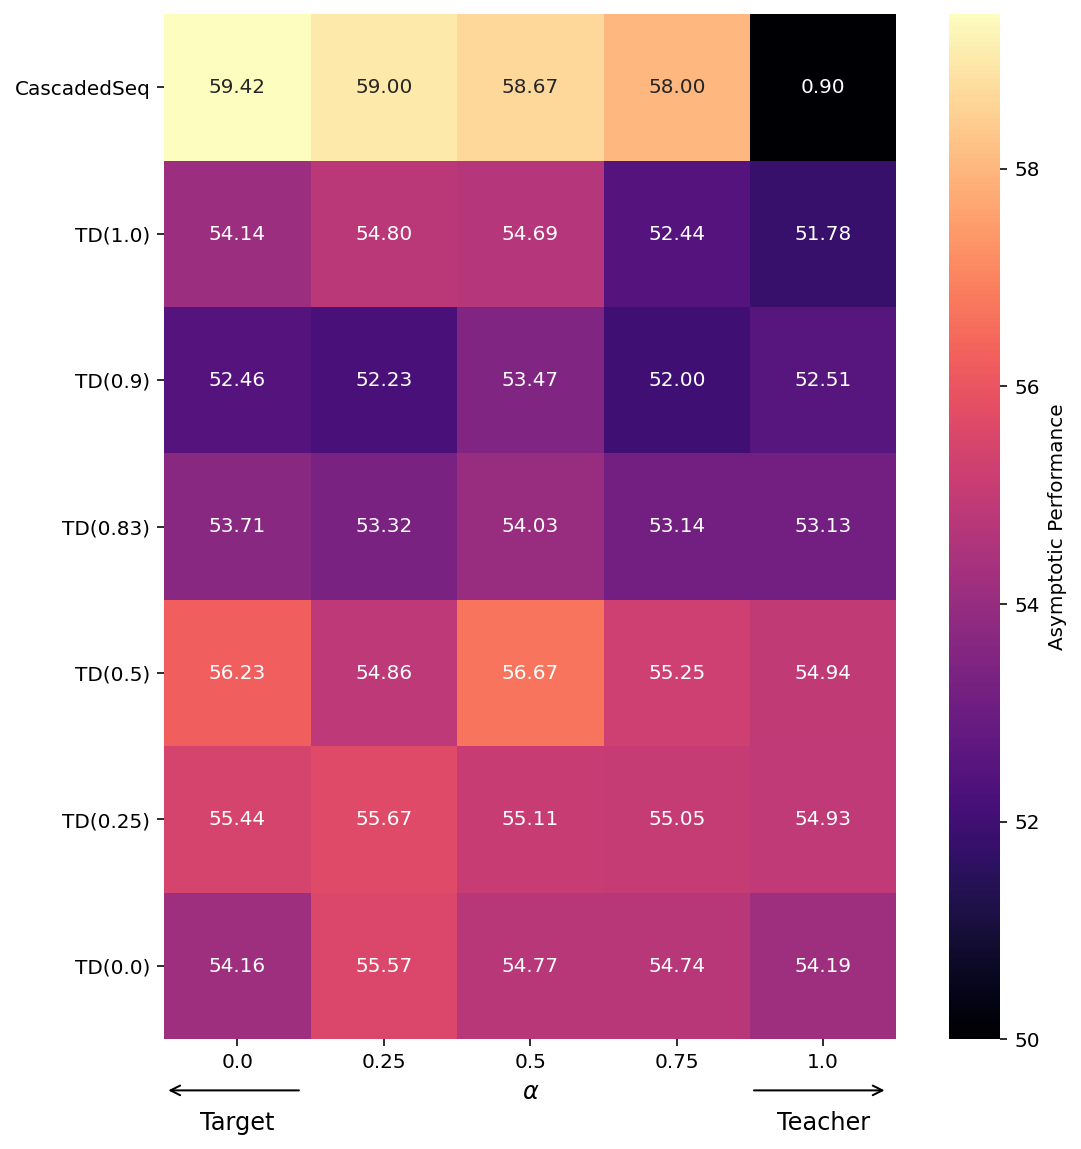

In [205]:
# pivot the dataframe from long to wide form
result = asymp_df.pivot(index="td_lambda", columns="alpha", values="asymp")

fix_ele = lambda x: f"TD({x})" if x >=0 else "CascadedSeq"
ytick_labels = [fix_ele(ele) for ele in result.index.to_list()][::-1]

cols = list(np.sort(result.columns.tolist()))
result = result[cols]
result = result.iloc[::-1]

result = result.loc[np.roll(result.index, 1)]
ytick_labels = np.roll(ytick_labels, 1)

VMIN = 50
plt.figure(figsize=(8,8))
mask = np.zeros_like(result)
mask[np.where(result==0)] = True

g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.2f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "Asymptotic Performance", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
)
g.set_xlabel(r"$\alpha$", fontsize=12)
# g.set_ylabel(r"$\lambda$", rotation=0, labelpad=20)
g.set_yticklabels(ytick_labels)
plt.yticks(rotation=0)
n_rows = len(result)
y_offset = n_rows + 0.35
plot_arrow(g, x_start=0.0, y=y_offset, text="Target", arrowstyle="->", fs=12)
plot_arrow(g, x_start=4.0, y=y_offset, text="Teacher", arrowstyle="<-", fs=12)
# plt.title(r"Asymptotic Performance: $\lambda$ vs. $\alpha$", fontsize=20)
g.set_ylabel("")
plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "asymptotic_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

### AUC Compute

In [194]:
def create_auc_df(df):
  save_keys = ["exp_key", "model", "td_lambda", "alpha", "distillation"]
  df_dict = defaultdict(list)
  for exp_key, df_i in df.groupby("exp_key"):
    Xs = np.array(df_i.timestep_mean)
    vals = np.array(df_i.acc_mean)
    norm = [100 for _ in vals]
    auc_val = np.trapz(vals, Xs) / np.trapz(norm, Xs)
    df_dict["auc"].append(auc_val)
    for key in save_keys:
      df_dict[key].append(df_i.iloc[0][key])
  auc_df = pd.DataFrame(df_dict)
  return auc_df

In [195]:
auc_df = create_auc_df(agg_df)
auc_df = auc_df.sort_values(['auc'], ascending=False).reset_index(drop=True)

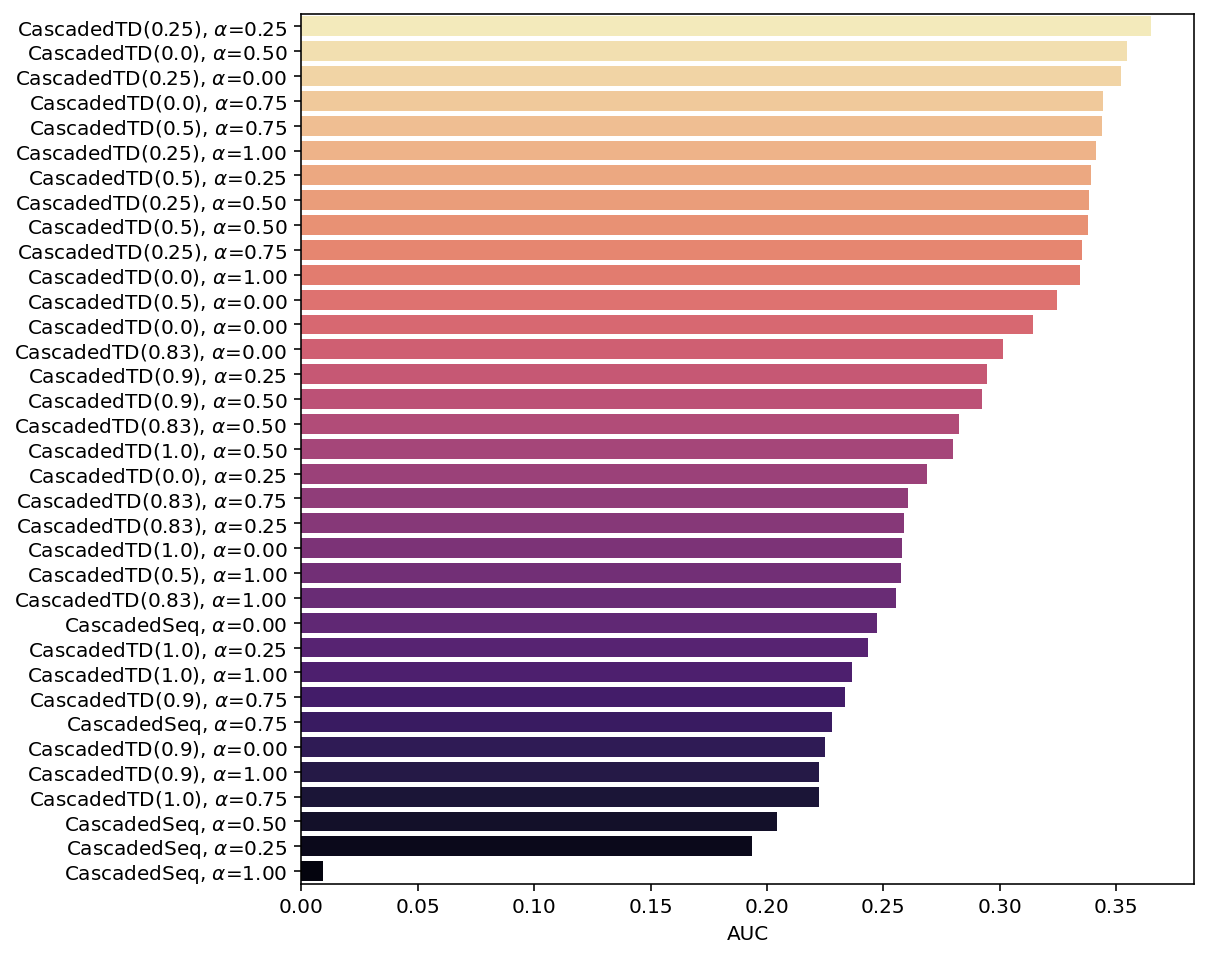

In [196]:
plt.figure(figsize=(8,8))
g = sns.barplot(y="exp_key", x="auc", data=auc_df, palette="magma_r")
g.set(xlabel="AUC", ylabel="");

### Heatmap

<ipython-input-190-369712ab86fa>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  g.annotate(
<ipython-input-190-369712ab86fa>:24: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  g.annotate(


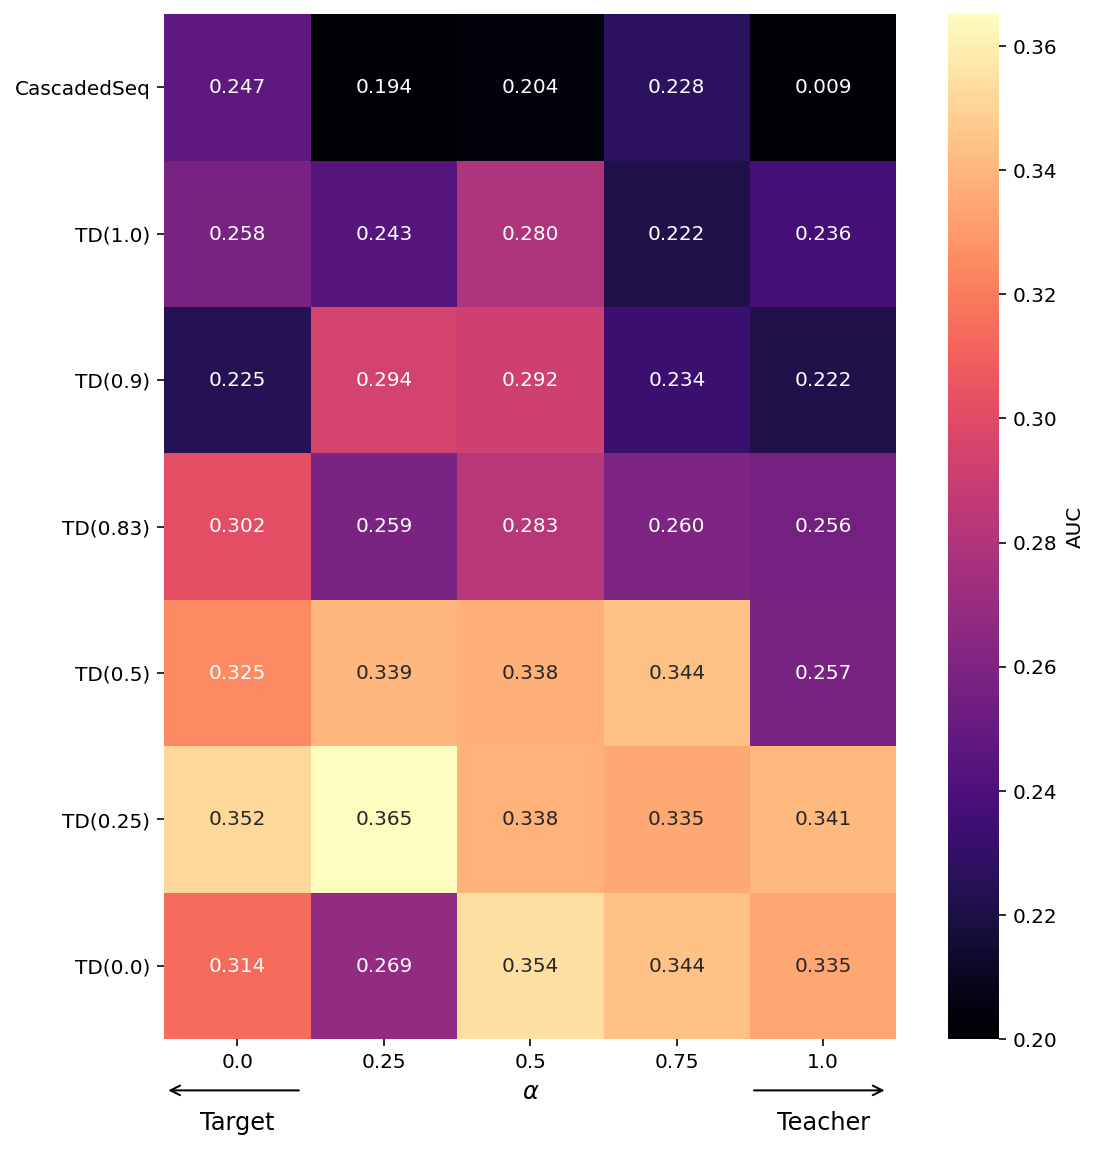

In [542]:
# pivot the dataframe from long to wide form
result = auc_df.pivot(index="td_lambda", columns="alpha", values="auc")
cols = list(np.sort(result.columns.tolist()))

ytick_labels = [fix_ele(ele) for ele in result.index.to_list()][::-1]
ytick_labels = [f"{ele}" for ele in ytick_labels]
result = result[cols]
result = result.iloc[::-1]

result = result.loc[np.roll(result.index, 1)]
ytick_labels = np.roll(ytick_labels, 1)

VMIN = 0.2
plt.figure(figsize=(8,8))
mask = np.zeros_like(result)
mask[np.where(result==0)] = True

g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.3f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "AUC", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
)
g.set_xlabel(r"$\alpha$", fontsize=12)
# g.set_ylabel(r"$\lambda$", rotation=0, labelpad=20)
g.set_yticklabels(ytick_labels)
plt.yticks(rotation=0)
n_rows = len(result)
y_offset = n_rows + 0.35
plot_arrow(g, x_start=0.0, y=y_offset, text="Target", arrowstyle="->", fs=12)
plot_arrow(g, x_start=4.0, y=y_offset, text="Teacher", arrowstyle="<-", fs=12)
# plt.title(r"Asymptotic Performance: $\lambda$ vs. $\alpha$", fontsize=20)
plt.tight_layout()
g.set_ylabel("")
pdf_save_path = os.path.join(figs_root, "auc_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

## Time Cost

In [534]:
betas = np.arange(0, 4, 0.1)
save_keys = ["exp_key", "model", "td_lambda", "alpha", "distillation"]
df_dict = defaultdict(list)
for exp_key, df_i in agg_df.groupby("exp_key"):
  Xs = np.array(df_i.timestep_mean)
  vals = np.array(df_i.acc_mean)
  for beta in betas:
    costs = []
    ts = range(len(Xs)-1)
    for t in ts:
      dx = Xs[t+1] - Xs[t]
      dy = vals[t+1] - vals[t]
      cost_i = dy * dx / ((t+1) ** beta)
      costs.append(cost_i)
    
    norm = [100 for _ in costs]
    auc = np.trapz(costs, ts) / np.trapz(norm, ts)
    df_dict["cost"].append(np.sum(costs))
    df_dict["auc"].append(auc)
    df_dict["beta"].append(beta)
    for key in save_keys:
      df_dict[key].append(df_i.iloc[0][key])
new_df = pd.DataFrame(df_dict)

In [535]:
df_list = []
for (model, td_lambda, beta), df_i in new_df.groupby(["model", "td_lambda", "beta"]):
  df_j = df_i.agg(np.mean).to_frame().T
  sem_df = df_i.agg(np.std).to_frame().T
  sem_cost = sem_df.iloc[0].cost / np.sqrt(len(df_i))
  sem_auc = sem_df.iloc[0].auc / np.sqrt(len(df_i))
  df_j.drop(columns=["alpha"], inplace=True)
  if model == "cascaded_seq":
    exp_key = "CascadedSeq"
  else:
    exp_key = f"CascadedTD({td_lambda})"
  df_j["sem_cost"] = sem_cost
  df_j["sem_auc"] = sem_auc
  df_j["model"] = model
  df_j["td_lambda"] = td_lambda
  df_j["exp_key"] = exp_key
  df_list.append(df_j)
alpha_agg_df = pd.concat(df_list)
alpha_agg_df.reset_index(drop=True, inplace=True)

In [538]:
for key in ["auc", "cost"]:
  for beta, df_i in alpha_agg_df.groupby("beta"):
    max_val = df_i[key].max()
    min_val = df_i[key].min()
    norm_fxn = lambda x: (x - min_val) / (max_val - min_val)
    relative_val = [norm_fxn(ele) for ele in df_i[key]]
    alpha_agg_df.loc[df_i.index, f"relative_{key}"] = relative_val

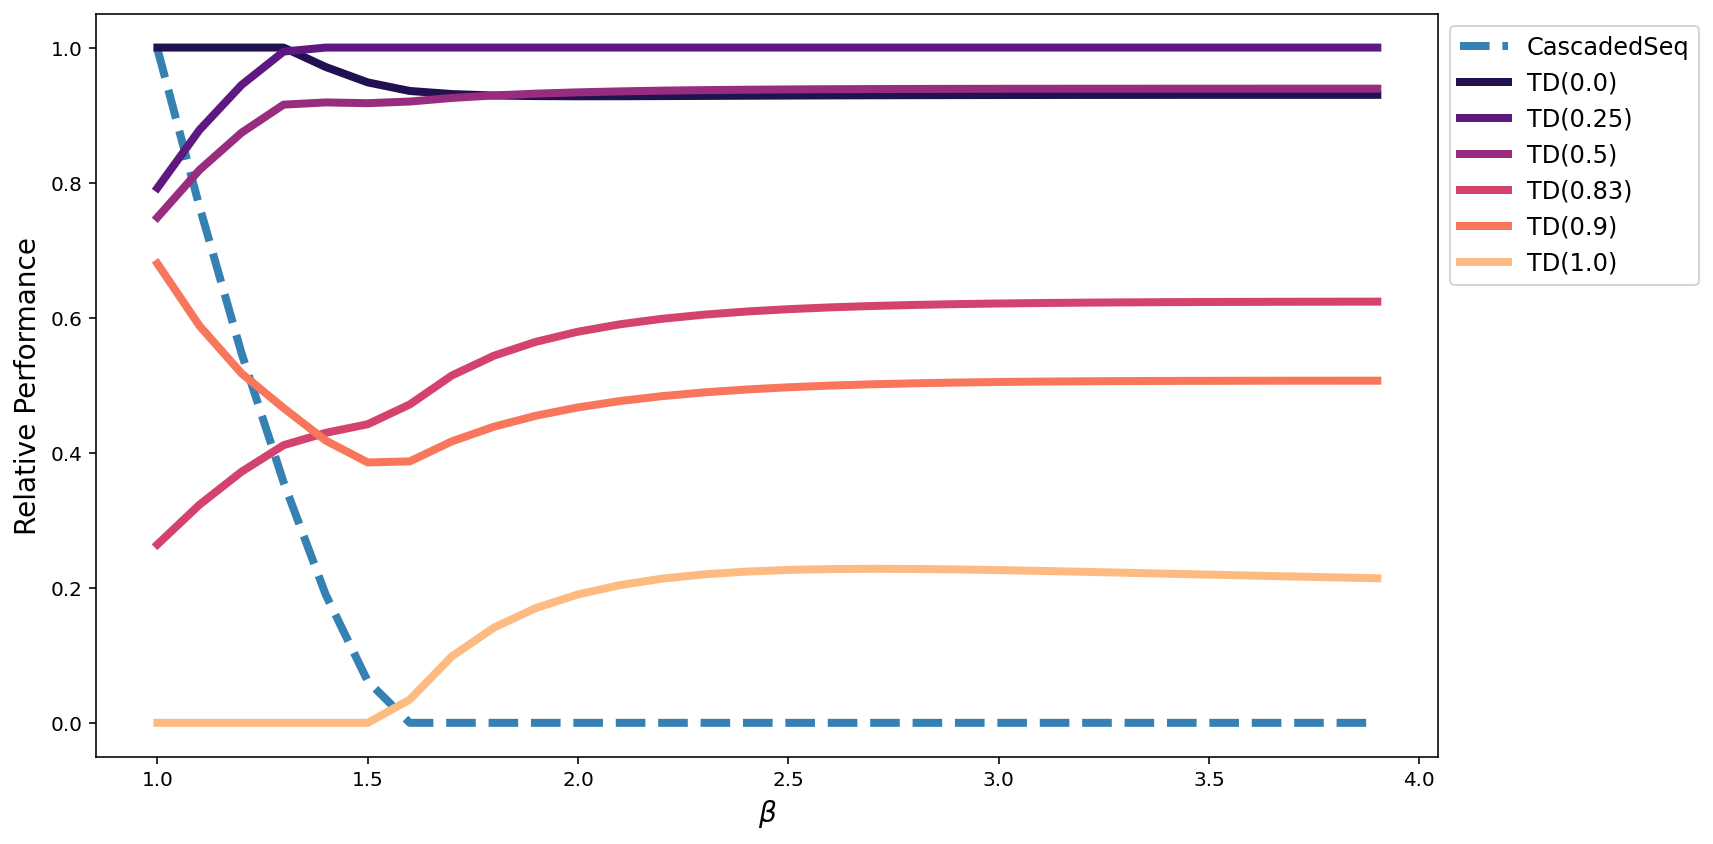

In [560]:
cmaps = {
  "cascaded": plt.cm.magma,
  "cascaded_seq": plt.cm.cool,
}
colors = {}
for model, df_i in agg_df.groupby("model"):
  cmap = cmaps[model]
  n_colors = len(df_i.groupby("td_lambda"))
  colors[model] = cmap(np.linspace(0, 1, n_colors+2))[1:-1]

plot_df = alpha_agg_df[alpha_agg_df.beta >= 1]
plt.figure(figsize=(12,6))
unique_td_lambdas = plot_df.td_lambda.unique()
unique_td_lambdas = list(unique_td_lambdas[unique_td_lambdas >= 0])
seen_labels = []
for i, (exp_key, df_i) in enumerate(plot_df.groupby("exp_key")):
  model_key = df_i.iloc[0].model
  td_lambda = df_i.iloc[0].td_lambda
  if model_key == "cascaded":
    idx = np.where(unique_td_lambdas==td_lambda)[0][0]
    color = colors[model_key][idx]
    ls = "-"
    label = f"TD({td_lambda})"
  else:
    color = CASCADED_SEQ_COLOR
    ls = "--"
    label = "CascadedSeq"
  if label in seen_labels:
    label = None
  seen_labels.append(label)
  plt.plot(
    list(df_i.beta),
    list(df_i.relative_cost),
    label=label,
    ls=ls,
    color=color,
    lw=4,
  )
  
#   yerr_1 = np.array(df_i.relative_cost) - np.array(df_i.sem_cost)
#   yerr_2 = np.array(df_i.relative_cost) + np.array(df_i.sem_cost)
#   plt.fill_between(
#     list(df_i.beta),
#     yerr_1,
#     yerr_2,
#     alpha=0.15,
#     color=color,
#   )
  
plt.legend(bbox_to_anchor=(1.0, 1.0), prop={"size": 12})
plt.xlabel(r"$\beta$", fontsize=14)
plt.ylabel("Relative Performance", fontsize=14);

plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "relative_cost.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)